# **HATESPEECH AND PROFANITY (OFFENSIVE LANGUAGE) DETECTION**

In [0]:
#!pip install vaderSentiment
#!pip install textstat
import re
import nltk
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
import string
import numpy as np
import pandas as pd
from nltk.stem.porter import *
from textstat.textstat import *
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

### Labeled Twitter data

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv")

In [5]:
print(list(df.columns))

['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']


### Tweet frequency in each class (Hate, offensive and neither)

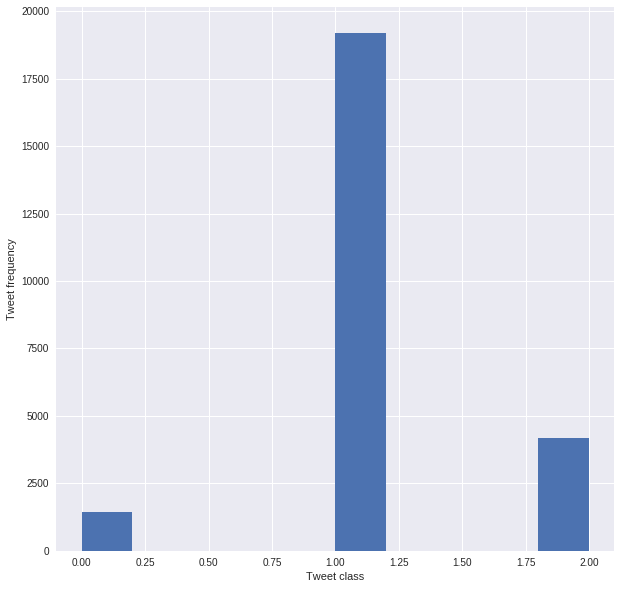

In [6]:
plt.figure(figsize=(10,10))
df['class'].hist()
plt.xlabel('Tweet class')
plt.ylabel('Tweet frequency')
#plt.savefig('1.png')
plt.show()

### Feature generation

In [0]:
tweets=df.tweet
stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(["#ff", "ff", "rt"])
stemmer = PorterStemmer()

def preprocess(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(tokenizer=tokenize,preprocessor=preprocess,ngram_range=(1, 3),stop_words=stopwords,use_idf=True,smooth_idf=False,norm=None,decode_error='replace',max_features=10000,min_df=5,max_df=0.501)

In [8]:
tfidf = vectorizer.fit_transform(tweets).toarray()

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [9]:
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [10]:
print(len(tweet_tags),tweet_tags)

24783 ['RB NN IN DT NN PRP VBP JJ NN IN VBG RP PRP$ NN NN IN DT NN PRP MD RB VB DT NN NN', 'JJ NN NN NNS VBP JJ JJ IN NN NN NN IN DT NN NN', 'JJ NN NN NN PRP RB VBD DT NN CC PRP VBP TO VB PRP VB VBN IN NN', 'NN VBZ PRP VBP IN DT NN', 'NN VBZ DT NN PRP VBP IN PRP MD VB JJ CC PRP MD VB JJR IN DT NN WP VBD PRP TO VB', 'IN DT NN RB VBZ NN PRP RB JJ CC RB IN NN CC RB VBG IN NN', 'NN NN MD RB RB VB RP CC VB IN DT NN NN NN VBD RB JJ NN VBG NN', 'NN NN NN VBP VBN IN PRP JJ NNS VBG IN PRP VBP NNS', 'NN PRP MD RB VB JJ VB RB JJ NNS WDT', 'NNS VBP VBG NNS NN', 'NN VBZ DT NN PRP VBZ NN NN NN VBD IN DT NN IN NN NN', 'NN NN VB PRP$ NN NN', 'RB VBZ IN NN VBP NNS . NN : VBP IN NN', 'JJ NNS VBZ DT JJ NN IN NN IN', 'NN VB RP IN PRP', 'NN NN VB PRP IN PRP', 'NN NN WDT', 'NN WP VBP PRP VB', 'NNS VBP VBN RP JJ NN', 'JJ NN VBD DT JJ NN', 'VBD NN NN VB PRP NN', 'NN WDT VBP IN NN', 'NN PRP VBP DT NNS VBP NN', 'NN DT WDT VBP VB RB JJ VBP DT NN NN NN TO VB VB RP', 'VBD PRP VB NN VBG IN PRP$ NN NNS', 'PRP$ JJ NN

In [0]:
pos_vectorizer = TfidfVectorizer(tokenizer=None,lowercase=False,preprocessor=None,ngram_range=(1, 3),stop_words=None,use_idf=False,smooth_idf=False,norm=None,decode_error='replace',max_features=5000,min_df=5,max_df=0.501,)

In [0]:
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()

In [13]:
print(tfidf.shape ,pos.shape)

(24783, 7086) (24783, 4063)


In [0]:
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    words = preprocess(tweet)
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[2], twitter_objs[1],twitter_objs[0], retweet]
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [0]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total","num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu","vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [16]:
feats = get_feature_array(tweets)
print(feats.shape)

(24783, 17)


In [17]:
Master = np.concatenate([tfidf,pos,feats],axis=1)
print(Master.shape)

(24783, 11166)


### Modelling
Best model is selected using grid seach cross validation

In [0]:
X,y = pd.DataFrame(Master),df['class'].astype(int)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [0]:
pipe = Pipeline( [('select', SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1", C=0.01))),('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [0]:
param_grid = [{}]

In [0]:
grid_search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5,  random_state=42).split(X_train, y_train), verbose=2)

In [23]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] ................................................. , total=   5.6s
[CV]  ................................................................
[CV] ................................................. , total=   5.7s
[CV]  ................................................................
[CV] ................................................. , total=   6.6s
[CV]  ................................................................
[CV] ................................................. , total=   5.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.4s finished


In [0]:
y_preds = model.predict(X_test)

### Results

In [0]:
report = classification_report( y_test, y_preds )

In [26]:
print(report)

             precision    recall  f1-score   support

          0       0.44      0.58      0.50       164
          1       0.96      0.91      0.94      1905
          2       0.83      0.94      0.88       410

avg / total       0.91      0.89      0.90      2479



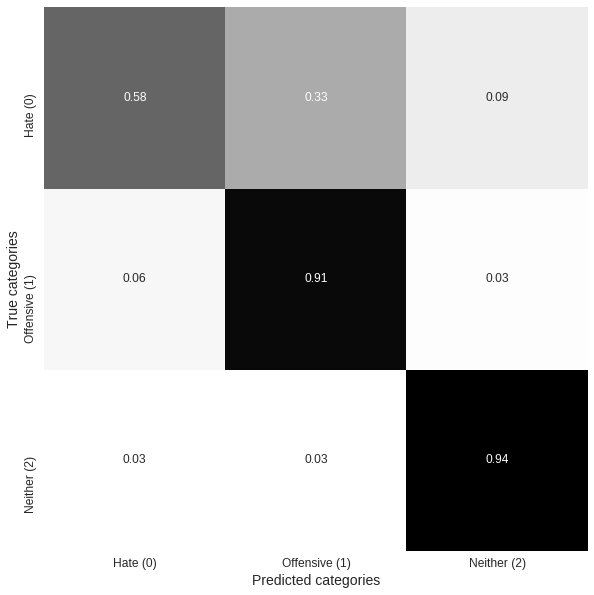

In [27]:
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate (0)','Offensive (1)','Neither (2)']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(10,10))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig('2.png')
plt.show()

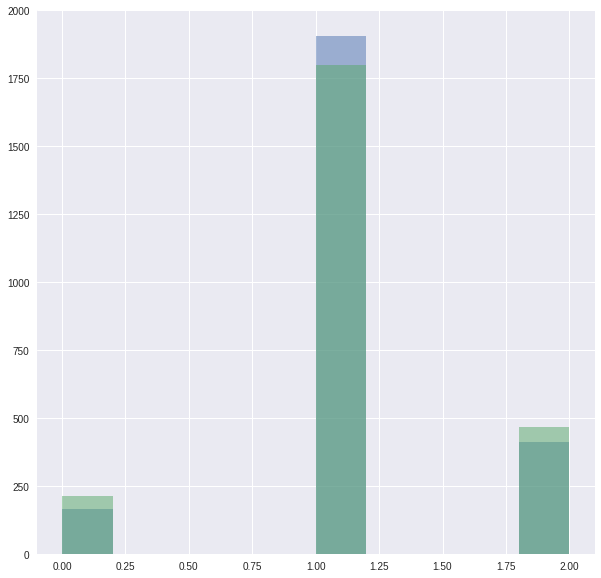

In [28]:
plt.figure(figsize=(10,10))
plt.hist(y_test,alpha=0.5)
plt.hist(y_preds,alpha=0.5)
plt.savefig('3.png')
plt.show()